In [10]:
import pandas as pd
import networkx as nx
import heapq
from utils.graph import KGraphPreproc
from sentence_transformers import SentenceTransformer

In [11]:
mqa_graph = KGraphPreproc.get_metaqa_graph()

In [12]:
mqa = pd.read_csv("/datasets/MetaQA/meta.csv")
mqa.head(1)

,id,hop,Question,topic_entity,Answer,actual_hops
0,1-0,1,what does [Grégoire Colin] appear in,Grégoire Colin,befor the rain,5


In [13]:
mqa.dropna(inplace=True)
# mqa[~mqa["Answer"].apply(lambda e: e in mqa_graph.preprocessed_nodes)]

In [14]:
mqa["chain"] = mqa.apply(
    lambda r: nx.shortest_path(
        mqa_graph._graph,
        mqa_graph.name2mid[r["topic_entity"]],
        mqa_graph.preprocessed_nodes[r.Answer]
    ),
    axis=1
)

In [15]:
mqa["actual_hops"].unique()

array([5, 2, 4, 7, 1, 6, 3, 8])

In [16]:
mqa.head()

,id,hop,Question,topic_entity,Answer,actual_hops,chain
0,1-0,1,what does [Grégoire Colin] appear in,Grégoire Colin,befor the rain,5,"[176, 173, 16, 540, 32794]"
1,1-1,1,[Joe Thomas] appears in which movies,Joe Thomas,the inbetween 2,2,"[20874, 20869]"
2,1-1,1,[Joe Thomas] appears in which movies,Joe Thomas,the inbetween movi,2,"[20874, 40449]"
3,1-2,1,what films did [Michelle Trachtenberg] star in,Michelle Trachtenberg,black christma,2,"[17337, 36835]"
4,1-2,1,what films did [Michelle Trachtenberg] star in,Michelle Trachtenberg,the scribbler,2,"[17337, 21532]"


In [8]:
def generate_inferential_chain(nodes):
    chain = f"{mqa_graph.mid2name[nodes[0]]}"
    for u,v in zip(nodes, nodes[1:]):
        tail = mqa_graph.mid2name[v]
        rel = mqa_graph._graph[u][v]["relation"]
        chain += f";{rel};{tail}"
    return chain

generate_inferential_chain(mqa.iloc[0]["chain"])

'Grégoire Colin;starred_actors;Before the Rain;has_genre;War;release_year;2007;release_year;Before the Rains'

### 1. Generate a small sample subset to verify predictions
group by hops and get 10% of each. 

Setting the 42 seed for reproducibility

In [17]:
mqa_subset = mqa.groupby("hop", group_keys=False).apply(lambda x: x.sample(n=1000, random_state=42))
mqa_subset.reset_index(inplace=True)
len(mqa_subset)

/tmp/ipykernel_3123/1302853177.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mqa_subset = mqa.groupby("hop", group_keys=False).apply(lambda x: x.sample(n=1000, random_state=42))


3000

In [18]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
device = torch.device("cuda:1")
torch.cuda.set_device(device)
torch.set_default_device(device)
import os
import threading
import queue
import time
from tqdm import tqdm
import gc
import csv

os.environ["HF_HOME"] = "/models"
os.environ["TRANSFORMERS_CACHE"] = "/models"

In [11]:
def create_model_instance():
    model_name = "Qwen/Qwen2.5-0.5B-Instruct"
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype="auto")
    model = model.to("cuda:1")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    def get_response(prompt, temperature=0.15):
        inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=False)
        outputs = model.generate(**inputs, max_length=400, temperature=temperature)
        text = tokenizer.batch_decode(outputs[:, inputs["input_ids"].shape[1]:])[0]
        return text
    return tokenizer, model, get_response


In [12]:
def save_results(fpath, data_rows):
    with open(fpath, "w") as f:
        writer = csv.writer(f)
        writer.writerow(["Model"])
        for r in data_rows:
            writer.writerow([str(r)])

In [19]:
def clear_cache():
    gc.collect()
    torch.cuda.empty_cache()

### 2. Generate edge predictions


In [ ]:
predict_link_prompt = '''
You are an expert in knowledge graphs and natural language understanding. Your task is to help explore relevant relationships from given topic entities that can aid in answering a question.
Instructions:
Input: You will be provided with a natural language question and a list of topic entities extracted from that question.
Objective: Analyze the question to understand its context and what information might be needed to answer it. Then, generate a list of 5 candidate relationship labels (i.e., edge types) that could be used to navigate a knowledge graph starting from each entity.
Requirements:
Relevance: The candidate relationship labels must be pertinent to the context of the question.
Conciseness: Provide a brief description (1–2 sentences) of why each relationship label might help answer the question.
Format: Return your answer as a numbered list in the following format: 1. (Entity; Relationship label; Reason)
Do not produce any other text.

Question: “What awards has Albert Einstein received?”
Topic Entities: Albert Einstein;
Candidate relationship labels (2 items):
1. (Albert Einstein; awardReceived; Connects a person to the awards they have received.)
2. (Albert Einstein; honorificAward; Links individuals to awards given in honor of their achievements.)

Question: “{question}”
Topic Entities: {entities}
Candidate relationship labels (5 items):
'''
# .format(question=q, entities="; ".join(e[::-1]))

In [20]:
res_path = "/datasets/MetaQA/results/link_prediction.csv"

In [ ]:
clear_cache()
tokenizer, model, get_response = create_model_instance()
print("model ready")

results = []
res_path = "/datasets/MetaQA/results/link_prediction.csv"
l = 0
# load if preinit'ed
if os.path.isfile(res_path):
    r_df = pd.read_csv(res_path)
    l = len(r_df)
    results = list(r_df.Model.values)


for i, r in tqdm(mqa_subset.iterrows()):
    if i < l:
        continue
    q_id = r["id"]
    entities = "; ".join([r["topic_entity"]])
    question = r.Question
    prompt = predict_link_prompt.format(
        question=question, entities=entities
    )
    response = get_response(prompt)
    results.append((
        q_id, response
    ))
    if i % 10 == 0:
        save_results(res_path, results)
save_results(res_path, results)
    


model ready


3000it [31:29,  1.59it/s]


### 3. Verify relation predictions
for each transition -> fetch the entire set of rel edges -> compare similarity with the correct one

In [15]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embed_sbert = lambda q: model.encode(q)
sbert_cache_path = "/datasets/MetaQA/cache/sbert.csv"

In [16]:
mqa_graph.embed_triplets(embedding_function=embed_sbert, cache_path=sbert_cache_path)

Checking embedding cache
Loading embedding cache


124680it [02:13, 932.13it/s]


In [23]:
import re
regex_mqa_topic_entity = re.compile("\[(.*?)\]")
def extract_rel_answer(answer_string, group=0):
    pattern = re.compile("\d+\.\s*\(([^;]+);\s*([^;]+);\s*(.+?)\)")
    pos = 0
    rels = []
    while m := pattern.search(answer_string, pos):
        pos = m.start() + 1
        entity, rel, reason = m[group].split(";")[:3]
        rels.append(rel.strip())
    return rels[:5]

In [21]:
import ast

In [25]:
pred_links = pd.read_csv(res_path)
pred_links.Model = pred_links.Model.apply(ast.literal_eval)
pred_links[["id", "pred_rels"]] = pred_links.Model.to_list()
pred_links.drop(columns=["Model"], inplace=True)
pred_links["pred_rels"] = pred_links["pred_rels"].apply(extract_rel_answer)
pred_links["pred_rels"] = pred_links["pred_rels"].apply(lambda t: ";".join(t))
# pred_links["pred_emb"] = pred_links["pred_rels"].apply(embed_sbert)
pred_links.head()

,id,pred_rels
0,1-1156,filmDirector;awardReceived;movie;awardReceived...
1,1-3193,directorOf;writerOf;producerOf
2,1-2772,director;genre;actor;screenplaywriter;cinemato...
3,1-169,starredIn;film;role;actor;film
4,1-1740,starredBy;directorOf;writerOf;producerOf;castM...


In [26]:
link_df = pred_links.merge(mqa_subset, on="id").drop_duplicates("id")
link_df.head(1)

,id,pred_rels,index,hop,Question,topic_entity,Answer,actual_hops,chain
0,1-1156,filmDirector;awardReceived;movie;awardReceived...,3486,1,[Phil Joanou] was the director of which movies,Phil Joanou,heaven s prison,2,"[5040, 14099]"


In [70]:
def get_retrieved_position(entry):
    """
    
    """
    start = entry["chain"][0]
    target = entry["chain"][1]
    cand_emb = entry["pred_emb"]
    links = []
    for link in mqa_graph._graph[start].values():
        score = model.similarity(link.get("embedding", []), cand_emb)
        heapq.heappush(links, (score, link.get("relation")))
    actual_link = mqa_graph._graph[start][target]["relation"]
    top_links = heapq.nlargest(len(links), links)
    for idx, (score, link) in enumerate(top_links):
        if link == actual_link:
            return idx
    return -1

In [71]:
link_df["retr_pos"] = link_df.apply(get_retrieved_position, axis=1)

<Axes: title={'center': 'Position of correct edge in reranking based on LLM-predicted candidates'}, xlabel='Retrieved position', ylabel='Frequency'>

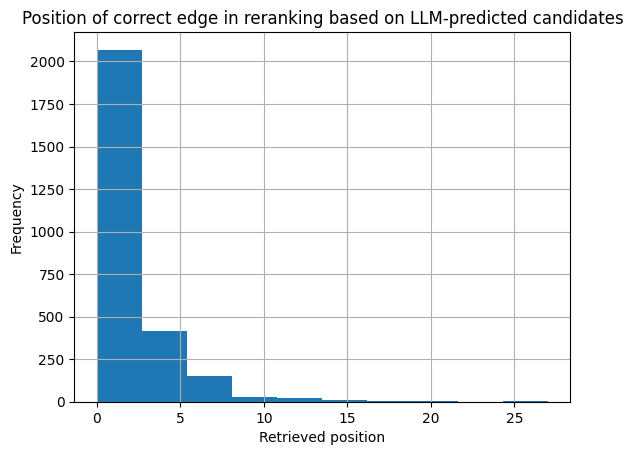

In [72]:
link_df["retr_pos"].plot.hist(xlabel="Retrieved position", title="Position of correct edge in reranking based on LLM-predicted candidates", grid=True)

<Axes: xlabel='rank', ylabel='% of correct edges retrieved'>

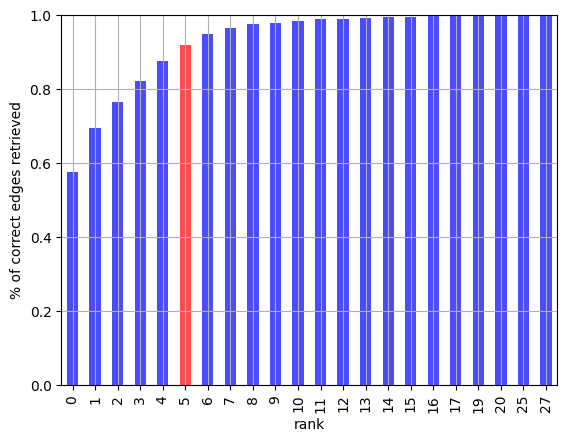

In [73]:
counts = link_df["retr_pos"].value_counts().sort_index()
cumsums = counts.cumsum()
cumsums = cumsums.to_frame()
cumsums["count"] = cumsums["count"]/link_df.shape[0]
c = ['red' if i==5 else 'blue' for i in cumsums.index]
# cumsums
cumsums["count"].plot.bar(grid=True, color=c, alpha=0.7, ylim=(0,1), ylabel="% of correct edges retrieved", xlabel="rank")

### **Use Recall@1/5/10 to quantify**

### 4. Generate tail entity predictions

Simply sort them by embedding similarity

In [27]:
def get_tails(node, edge):
    tails = set()
    for u,v,attrs in mqa_graph._graph.edges(node, data=True):
        if attrs.get("relation") == edge:
            tails.add(v)
    return tails

In [28]:
row = mqa.iloc[1]

In [29]:
start = row.chain[0]
target = row.chain[1]
edge = mqa_graph._graph[start][target]["relation"]
cand_tails = get_tails(start, edge)
print(
    mqa_graph.mid2name[start],
    edge,
    list(map(lambda t: mqa_graph.mid2name[t], cand_tails)),
    sep="\n"
)

Joe Thomas
starred_actors
['The Inbetweeners Movie', 'The Inbetweeners 2']


In [22]:
list(mqa_graph._graph.nodes(0))[1]

(1, None)

In [58]:
def local_relative_degree(node, path):
    # node_degree = mqa_graph._graph.degree(node)
    local_degree = 0
    neighbors = set(mqa_graph._graph.neighbors(node))
    for n in path:
        if n in neighbors:
            local_degree += 1
    # / node_degree
    return local_degree / len(path)

In [54]:
def get_reranked_tail_position(row):
    question = row.Question
    # retrieved position at each step
    step_retrieved_position = []
    path = []
    for step, (start, target) in enumerate(zip(row.chain, row.chain[1:])):
        # -1 - no position by default
        step_retrieved_position.append(-1)
        edge = mqa_graph._graph[start][target]["relation"]
        candidate_tails = get_tails(start, edge)
        path.extend([mqa_graph.mid2name[start], edge])
        # embed question + chain so far
        # rank by similarity
        top_tails = []
        for tail in candidate_tails:
            score = local_relative_degree(tail, path[::2])
            heapq.heappush(top_tails, (score, tail))
        # chain_so_far = ";".join(path)
        # q_emb = embed_sbert(question + "\n" + chain_so_far)
        # for tail in candidate_tails:
        #     tail_emb = embed_sbert(mqa_graph.mid2name[tail])
        #     score = model.similarity(q_emb, tail_emb)
        #     heapq.heappush(top_tails, (score, tail))

        # find the retrieved position
        top_tails = heapq.nlargest(len(top_tails), top_tails)
        for idx, (score, tail) in enumerate(top_tails):
            if tail == target:
                step_retrieved_position[step] = idx
    pbar.update(1)
    return step_retrieved_position
        

In [55]:
pbar = tqdm(total=len(mqa))
tail_df = mqa.apply(
    get_reranked_tail_position,
    axis=1
)

100%|█████████▉| 302415/302514 [04:51<00:00, 520.11it/s] 

In [86]:
tail_df

0           [0, 0, 0, 172]
1                      [1]
2                      [0]
3                      [1]
4                      [3]
                ...       
302519           [0, 4, 2]
302520                 [1]
302521           [0, 0, 0]
302522    [0, 0, 4, 17, 5]
302523           [0, 0, 0]
Length: 302514, dtype: object

In [57]:
tail_df.apply(pd.Series).describe()

,0,1,2,3,4,5,6
count,302500.000000,282352.000000,200028.000000,23901.000000,12513.000000,188.000000,1.0
mean,1.490245,274.732883,32.947292,104.088783,6.208104,0.329787,0.0
std,4.389650,848.433718,285.824700,475.626549,78.622077,2.239119,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.0
50%,1.000000,9.000000,0.000000,4.000000,0.000000,0.000000,0.0
75%,2.000000,25.000000,2.000000,13.000000,1.000000,0.000000,0.0
max,477.000000,4175.000000,4174.000000,4166.000000,2361.000000,27.000000,0.0


In [78]:
tail_df[tail_df.apply(lambda ps: ps[1] if len(ps) > 1 else -1) > 5]

153               [5, 14, 1]
2362             [12, 6, 79]
4162           [16, 16, 807]
4195              [0, 19, 1]
4203               [2, 9, 0]
                 ...        
302480            [0, 18, 0]
302481            [0, 22, 0]
302508           [0, 293, 0]
302511    [0, 105, 1, 22, 4]
302516           [0, 242, 3]
Length: 168065, dtype: object

<Axes: ylabel='Frequency'>

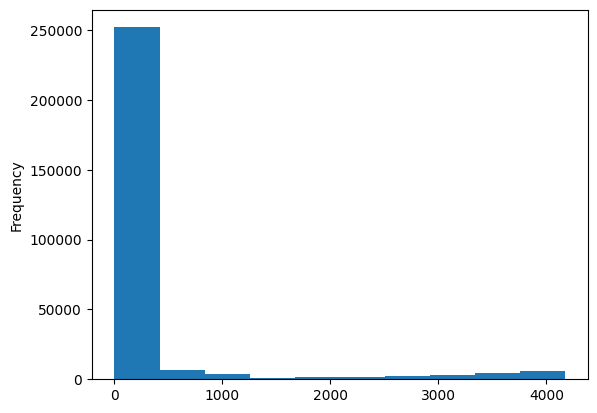

In [90]:
tail_df.apply(lambda ps: ps[1] if len(ps) > 1 else np.nan).plot.hist()

local connectivity

In [6]:
def get_reranked_tail_position(row):
    question = row.Question
    # retrieved position at each step
    step_retrieved_position = []
    path = []
    for step, (start, target) in enumerate(zip(row.chain, row.chain[1:])):
        # -1 - no position by default
        step_retrieved_position.append(-1)
        edge = mqa_graph._graph[start][target]["relation"]
        candidate_tails = get_tails(start, edge)
        path.extend([mqa_graph.mid2name[start], edge])
        
        top_tails = []
        # embed question + chain so far
        # chain_so_far = ";".join(path)
        # q_emb = embed_sbert(question + "\n" + chain_so_far)
        # # rank by similarity
        # for tail in candidate_tails:
        #     tail_emb = embed_sbert(mqa_graph.mid2name[tail])
        #     score = model.similarity(q_emb, tail_emb)
        #     heapq.heappush(top_tails, (score, tail))

        
        # find the retrieved position
        top_tails = heapq.nlargest(len(top_tails), top_tails)
        for idx, (score, tail) in enumerate(top_tails):
            if tail == target:
                step_retrieved_position[step] = idx
    return step_retrieved_position
        

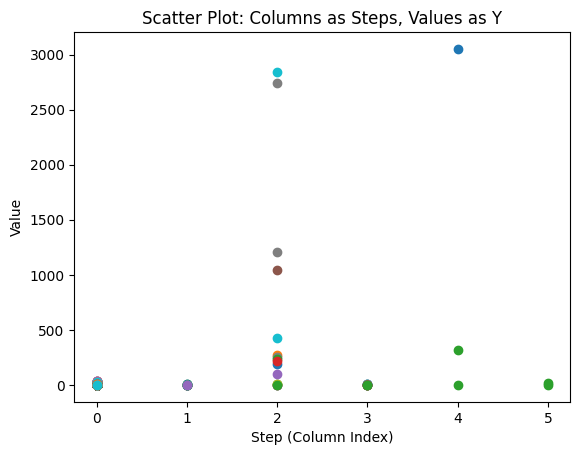

In [99]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

# Iterate through each row and plot the scatter points
for idx, row in tail_df.apply(pd.Series).iterrows():
    # Drop NaN values (from rows that are shorter than the max length)
    valid_data = row.dropna()
    
    # x-values: the column indices (steps)
    x = valid_data.index.astype(int)
    # y-values: the corresponding values in the row
    y = valid_data.values.astype(float)
    
    ax.scatter(x, y, label=f'Row {idx}')

# Label axes and add a title
ax.set_xlabel('Step (Column Index)')
ax.set_ylabel('Value')
ax.set_title('Scatter Plot: Columns as Steps, Values as Y')

# Optional: Add a legend if you want to identify the rows
# ax.legend()

plt.show()

Study local node connectivity

### 5. Verify entity predictions

In [ ]:
def rerank_tails(question, node, edge, candidate)